In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, GlobalMaxPooling1D, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import re, emoji
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory


In [31]:
df = pd.read_csv("../data/raw/email_spam_indo.csv")
df.head()


,Kategori,Pesan
0,spam,Secara alami tak tertahankan identitas perusah...
1,spam,Fanny Gunslinger Perdagangan Saham adalah Merr...
2,spam,Rumah -rumah baru yang luar biasa menjadi muda...
3,spam,4 Permintaan Khusus Pencetakan Warna Informasi...
4,spam,"Jangan punya uang, dapatkan CD perangkat lunak..."


In [32]:
STOPWORDS = set(StopWordRemoverFactory().get_stop_words())
STOPWORDS.update([
    "hou","kaminski","vince","enron","corp","edu","cc","re","fw",
    "subject","email","houston","pm","am","com","net","org",
    "ltd","co","inc","ect"
])

URL_RE = re.compile(r'https?://\S+|www\.\S+')
EMAIL_RE = re.compile(r'\S+@\S+')
NON_ALPHA = re.compile(r'[^a-zA-Z\s]')

def strip_emoji(text):
    try:
        return emoji.replace_emoji(text, replace=" ")
    except:
        return text

def clean_text(t):
    t = t.lower()
    t = URL_RE.sub(" ", t)
    t = EMAIL_RE.sub(" ", t)
    t = strip_emoji(t)
    t = NON_ALPHA.sub(" ", t)
    return " ".join([w for w in t.split() if w not in STOPWORDS and len(w) > 2])


In [33]:
df["clean"] = df["Pesan"].apply(clean_text)

X = df["clean"]
y = df["Kategori"]

le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)


# experiment 1 tfidf + cnn

In [34]:
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_test_tfidf  = tfidf.transform(X_test).toarray()

X_train_cnn = np.expand_dims(X_train_tfidf, axis=2)
X_test_cnn  = np.expand_dims(X_test_tfidf, axis=2)


In [35]:
from tensorflow.keras import layers, models

model_tfidf = models.Sequential([
    layers.Conv1D(128, 5, activation='relu', input_shape=(5000, 1)),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(le.classes_), activation='softmax')
])

model_tfidf.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model_tfidf.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 4996, 128)         768       
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 2498, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_4 (Conv1D)           (None, 2496, 64)          24640     
                                                                 
 global_max_pooling1d_2 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 2)                

In [36]:
history_tfidf = model_tfidf.fit(
    X_train_cnn, y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=32
)


Epoch 1/10
60/60 [==============================] - 8s 131ms/step - loss: 0.6931 - accuracy: 0.5319 - val_loss: 0.6930 - val_accuracy: 0.5118
Epoch 2/10
60/60 [==============================] - 7s 115ms/step - loss: 0.6901 - accuracy: 0.5351 - val_loss: 0.6820 - val_accuracy: 0.6588
Epoch 3/10
60/60 [==============================] - 7s 114ms/step - loss: 0.6825 - accuracy: 0.5683 - val_loss: 0.6651 - val_accuracy: 0.6256
Epoch 4/10
60/60 [==============================] - 7s 116ms/step - loss: 0.6759 - accuracy: 0.5841 - val_loss: 0.6530 - val_accuracy: 0.6635
Epoch 5/10
60/60 [==============================] - 7s 115ms/step - loss: 0.6742 - accuracy: 0.5814 - val_loss: 0.6497 - val_accuracy: 0.6777
Epoch 6/10
60/60 [==============================] - 7s 120ms/step - loss: 0.6739 - accuracy: 0.5851 - val_loss: 0.6468 - val_accuracy: 0.6445
Epoch 7/10
60/60 [==============================] - 7s 120ms/step - loss: 0.6729 - accuracy: 0.5793 - val_loss: 0.6441 - val_accuracy: 0.6730
Epoch 

In [37]:
pred_tfidf = model_tfidf.predict(X_test_cnn).argmax(axis=1)

print("TF-IDF Accuracy:", accuracy_score(y_test, pred_tfidf))
print(classification_report(y_test, pred_tfidf, target_names=le.classes_))


17/17 [==============================] - 1s 38ms/step
TF-IDF Accuracy: 0.6079545454545454
              precision    recall  f1-score   support

         ham       0.60      0.55      0.57       254
        spam       0.61      0.66      0.64       274

    accuracy                           0.61       528
   macro avg       0.61      0.61      0.61       528
weighted avg       0.61      0.61      0.61       528



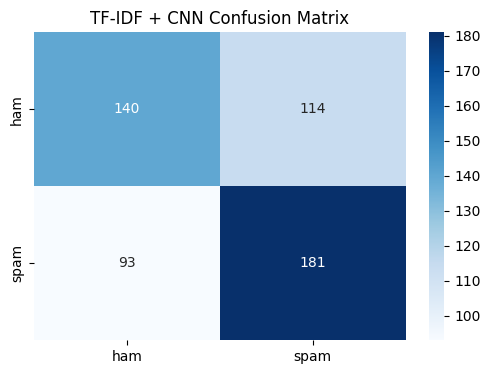

In [38]:
cm = confusion_matrix(y_test, pred_tfidf)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("TF-IDF + CNN Confusion Matrix")
plt.show()


# experiment 2 tokenizer+embedding+cnn

In [39]:
max_words = 5000
max_len = 300

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len)
X_test_seq  = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len)


In [40]:
cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
cnn_model.add(Conv1D(64, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(32, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(len(le.classes_), activation='softmax'))

cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 128)          640000    
                                                                 
 conv1d_5 (Conv1D)           (None, 296, 64)           41024     
                                                                 
 global_max_pooling1d_3 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 2)                 66        
                                                      

In [41]:
history_tok = cnn_model.fit(
    X_train_seq, y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=32
)


Epoch 1/10
60/60 [==============================] - 1s 18ms/step - loss: 0.5829 - accuracy: 0.7190 - val_loss: 0.3558 - val_accuracy: 0.9052
Epoch 2/10
60/60 [==============================] - 1s 16ms/step - loss: 0.1941 - accuracy: 0.9562 - val_loss: 0.1016 - val_accuracy: 0.9668
Epoch 3/10
60/60 [==============================] - 1s 16ms/step - loss: 0.0475 - accuracy: 0.9910 - val_loss: 0.0939 - val_accuracy: 0.9573
Epoch 4/10
60/60 [==============================] - 1s 16ms/step - loss: 0.0148 - accuracy: 0.9995 - val_loss: 0.0827 - val_accuracy: 0.9621
Epoch 5/10
60/60 [==============================] - 1s 18ms/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.0910 - val_accuracy: 0.9573
Epoch 6/10
60/60 [==============================] - 1s 17ms/step - loss: 0.0061 - accuracy: 0.9984 - val_loss: 0.0907 - val_accuracy: 0.9621
Epoch 7/10
60/60 [==============================] - 1s 17ms/step - loss: 0.0057 - accuracy: 0.9989 - val_loss: 0.0914 - val_accuracy: 0.9526
Epoch 8/10
60

In [42]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

In [48]:
import os
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Pastikan folder logs ada
os.makedirs("../outputs/logs", exist_ok=True)

# ===== Prediction =====
pred_tok = cnn_model.predict(X_test_seq).argmax(axis=1)

# ===== Metrics =====
acc  = accuracy_score(y_test, pred_tok)
prec = precision_score(y_test, pred_tok, average='macro')
rec  = recall_score(y_test, pred_tok, average='macro')
f1   = f1_score(y_test, pred_tok, average='macro')

print("===== Tokenizer CNN Results =====")
print(f"Accuracy: {acc:.4f}")
print(f"Precision (macro): {prec:.4f}")
print(f"Recall (macro): {rec:.4f}")
print(f"F1-score (macro): {f1:.4f}")

print("\nFull Classification Report:\n")
print(classification_report(y_test, pred_tok, target_names=le.classes_, digits=4))


# ============================================================
# EXPORT: METRICS → CSV
# ============================================================

metrics_dict = {
    "Accuracy": [round(acc, 4)],
    "Precision_macro": [round(prec, 4)],
    "Recall_macro": [round(rec, 4)],
    "F1_macro": [round(f1, 4)]
}

df_metrics = pd.DataFrame(metrics_dict)

save_path = "../outputs/logs/tokenizer_cnn_metrics.csv"
df_metrics.to_csv(save_path, index=False)

print(f"\n[SAVED] Metrics exported → {save_path}")


# ============================================================
# EXPORT: CLASSIFICATION REPORT → CSV
# ============================================================

report = classification_report(
    y_test,
    pred_tok,
    target_names=le.classes_,
    output_dict=True
)

df_report = pd.DataFrame(report).transpose()
report_path = "../outputs/logs/tokenizer_cnn_classification_report.csv"
df_report.to_csv(report_path)

print(f"[SAVED] Classification report exported → {report_path}")


17/17 [==============================] - 0s 4ms/step
===== Tokenizer CNN Results =====
Accuracy: 0.9811
Precision (macro): 0.9812
Recall (macro): 0.9809
F1-score (macro): 0.9810

Full Classification Report:

              precision    recall  f1-score   support

         ham     0.9841    0.9764    0.9802       254
        spam     0.9783    0.9854    0.9818       274

    accuracy                         0.9811       528
   macro avg     0.9812    0.9809    0.9810       528
weighted avg     0.9811    0.9811    0.9811       528


[SAVED] Metrics exported → ../outputs/logs/tokenizer_cnn_metrics.csv
[SAVED] Classification report exported → ../outputs/logs/tokenizer_cnn_classification_report.csv


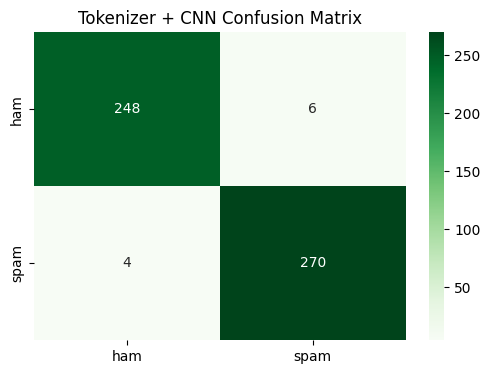

In [44]:
cm2 = confusion_matrix(y_test, pred_tok)

plt.figure(figsize=(6,4))
sns.heatmap(cm2, annot=True, fmt="d", cmap="Greens",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Tokenizer + CNN Confusion Matrix")
plt.savefig("../outputs/logs/tokenizer_cnn_confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()


In [45]:
import os
import matplotlib.pyplot as plt

# Pastikan folder ../outputs/plots dibuat
PLOT_DIR = "../outputs/logs/"
os.makedirs(PLOT_DIR, exist_ok=True)

def compare_training_curves(histories, labels, title="Training Curve Comparison", save_path=None):
    """
    histories : list of Keras History objects
    labels    : list of model names (TF-IDF + CNN, Tokenizer + CNN)
    """

    plt.figure(figsize=(16, 6))

    # =============================
    # SUBPLOT 1 — ACCURACY
    # =============================
    plt.subplot(1, 2, 1)

    for history, label in zip(histories, labels):
        plt.plot(history.history["accuracy"], label=f"{label} Train")
        plt.plot(history.history["val_accuracy"], linestyle="--", label=f"{label} Val")

    plt.title("Accuracy Comparison (TF-IDF vs Embedding)")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    # =============================
    # SUBPLOT 2 — LOSS
    # =============================
    plt.subplot(1, 2, 2)

    for history, label in zip(histories, labels):
        plt.plot(history.history["loss"], label=f"{label} Train")
        plt.plot(history.history["val_loss"], linestyle="--", label=f"{label} Val")

    plt.title("Loss Comparison (TF-IDF vs Embedding)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"[SAVED] → {save_path}")

    plt.show()


[SAVED] → ../outputs/logs/training_curve_comparison.png


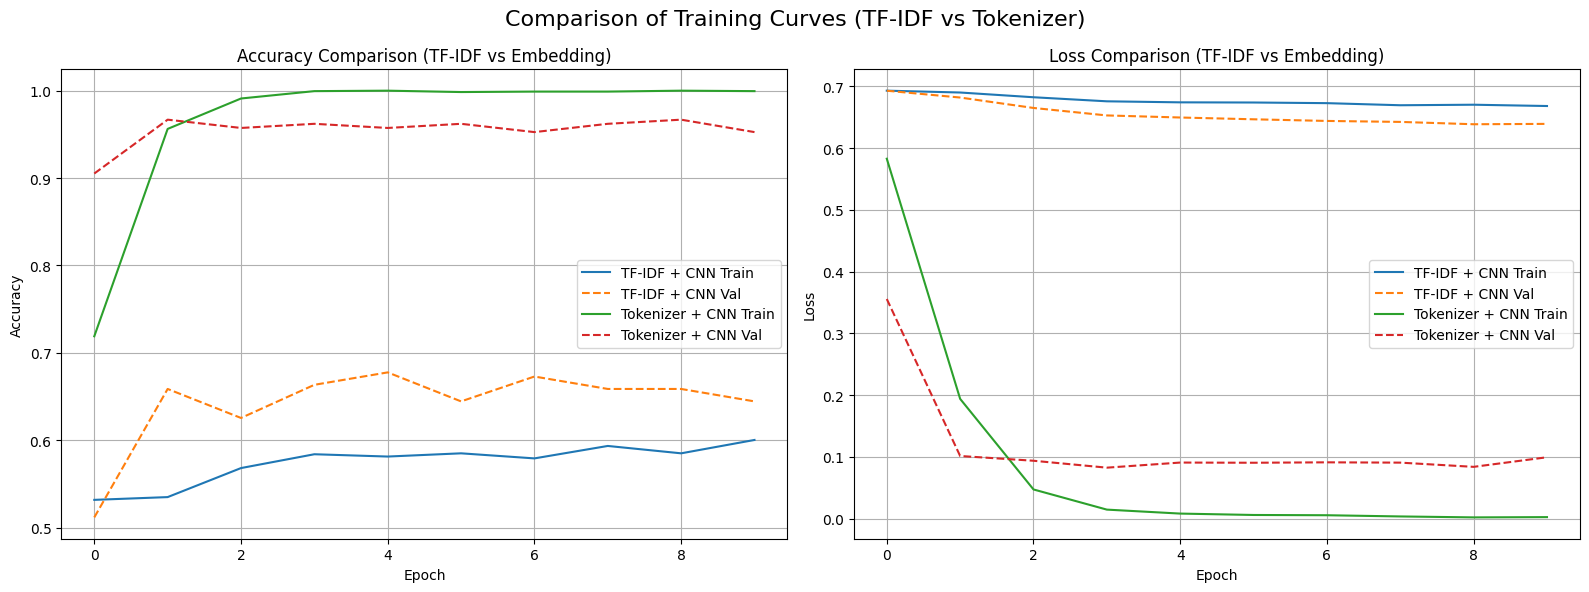

In [46]:
histories = [history_tfidf, history_tok]
labels = ["TF-IDF + CNN", "Tokenizer + CNN"]

compare_training_curves(
    histories,
    labels,
    title="Comparison of Training Curves (TF-IDF vs Tokenizer)",
    save_path="../outputs/logs/training_curve_comparison.png"
)
